<a href="https://colab.research.google.com/github/SharmisthaChitransh/VAE-/blob/main/VAE1000.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# STEP 0: Install dependencies
!pip install torchvision matplotlib tqdm --quiet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 98.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 95.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 56.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 835.4 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 104.1 MB/s eta 0:00:00


In [4]:
# STEP 2: Setup folder paths and parameters
import os
import torch

drive_path = "/content/drive/MyDrive/VAE"
os.makedirs(drive_path, exist_ok=True)

IMG_SIZE = 128
NUM_SAMPLES = 1000
BATCH_SIZE = 32
LATENT_DIM = 32
EPOCHS = 15
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"



In [5]:
# STEP 3: Download and filter Galaxy Zoo data
import pandas as pd

df = pd.read_csv("https://gz2hart.s3.amazonaws.com/gz2_hart16.csv.gz", compression='gzip')
filtered = df[
    (df['t01_smooth_or_features_a01_smooth_fraction'] > 0.1) &
    (df['t01_smooth_or_features_a02_features_or_disk_fraction'] > 0.1) &
    (df['t01_smooth_or_features_a03_star_or_artifact_fraction'] > 0.0)
]
sample = filtered.sample(n=NUM_SAMPLES, random_state=42).reset_index(drop=True)


In [6]:
# STEP 4: Download images to Drive with tqdm
from tqdm import tqdm
from PIL import Image
import requests
from io import BytesIO

image_folder = f"{drive_path}/galaxy_images"
os.makedirs(image_folder, exist_ok=True)

for i, row in tqdm(sample.iterrows(), total=len(sample), desc="Downloading images"):
    ra, dec = row['ra'], row['dec']
    path = f"{image_folder}/galaxy_{i}.jpg"
    if not os.path.exists(path):
        try:
            url = f"https://skyserver.sdss.org/dr16/SkyServerWS/ImgCutout/getjpeg?ra={ra}&dec={dec}&scale=0.396&width={IMG_SIZE}&height={IMG_SIZE}"
            response = requests.get(url, timeout=5)
            img = Image.open(BytesIO(response.content)).convert("RGB")
            img.save(path)
        except:
            Image.new("RGB", (IMG_SIZE, IMG_SIZE), color='black').save(path)


In [7]:
# STEP 5: Dataset and DataLoader
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])

class GalaxyZooDataset(Dataset):
    def __init__(self, df, folder, transform=None):
        self.df = df
        self.folder = folder
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        path = f"{self.folder}/galaxy_{idx}.jpg"
        image = Image.open(path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        row = self.df.iloc[idx]
        y = torch.tensor([
            row['t01_smooth_or_features_a01_smooth_fraction'],
            row['t01_smooth_or_features_a02_features_or_disk_fraction'],
            row['t01_smooth_or_features_a03_star_or_artifact_fraction']
        ], dtype=torch.float32)
        return image, y

dataset = GalaxyZooDataset(sample, folder=image_folder, transform=transform)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)


In [8]:
# STEP 6: Define VAE model with classifier
import torch.nn as nn
import torch.nn.functional as F

class PoseInvariantVAE(nn.Module):
    def __init__(self, latent_dim=32):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, 4, 2, 1), nn.ReLU(),
            nn.Conv2d(16, 32, 4, 2, 1), nn.ReLU(),
            nn.Conv2d(32, 64, 4, 2, 1), nn.ReLU(),
            nn.Flatten()
        )
        self.flattened_size = 64 * 16 * 16
        self.pose = nn.Linear(self.flattened_size, self.flattened_size)
        self.fc_mu = nn.Linear(self.flattened_size, latent_dim)
        self.fc_logvar = nn.Linear(self.flattened_size, latent_dim)
        self.decoder_input = nn.Linear(latent_dim, self.flattened_size)
        self.decoder = nn.Sequential(
            nn.Unflatten(1, (64, 16, 16)),
            nn.ConvTranspose2d(64, 32, 4, 2, 1), nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 4, 2, 1), nn.ReLU(),
            nn.ConvTranspose2d(16, 3, 4, 2, 1), nn.Sigmoid()
        )
        self.classifier = nn.Sequential(
            nn.Linear(latent_dim, 64), nn.ReLU(),
            nn.Linear(64, 3), nn.Softmax(dim=1)
        )

    def encode(self, x):
        x = self.encoder(x)
        x = self.pose(x)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        x = self.decoder_input(z)
        return self.decoder(x)

    def classify(self, z):
        return self.classifier(z)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decode(z)
        y_pred = self.classify(z)
        return x_recon, y_pred, mu, logvar


In [9]:
# STEP 7: Train the model
def elbo_loss(x_recon, x, mu, logvar):
    recon_loss = F.mse_loss(x_recon, x, reduction='mean')
    kl = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl

def classification_rmse(y_pred, y_true):
    return torch.sqrt(F.mse_loss(y_pred, y_true, reduction='mean'))

model = PoseInvariantVAE(latent_dim=LATENT_DIM).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(EPOCHS):
    model.train()
    epoch_loss = 0.0
    for X_batch, y_batch in dataloader:
        X_batch, y_batch = X_batch.to(DEVICE), y_batch.to(DEVICE)
        optimizer.zero_grad()
        x_recon, y_pred, mu, logvar = model(X_batch)
        loss = elbo_loss(x_recon, X_batch, mu, logvar) + classification_rmse(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    print(f"Epoch {epoch+1}/{EPOCHS} - Avg Loss: {epoch_loss/len(dataloader):.4f}")


Epoch 1/15 - Avg Loss: 0.6315
Epoch 2/15 - Avg Loss: 0.2266
Epoch 3/15 - Avg Loss: 0.1994
Epoch 4/15 - Avg Loss: 0.1938
Epoch 5/15 - Avg Loss: 0.1901
Epoch 6/15 - Avg Loss: 0.1890
Epoch 7/15 - Avg Loss: 0.1907
Epoch 8/15 - Avg Loss: 0.1881
Epoch 9/15 - Avg Loss: 0.1871
Epoch 10/15 - Avg Loss: 0.1887
Epoch 11/15 - Avg Loss: 0.1856
Epoch 12/15 - Avg Loss: 0.1875
Epoch 13/15 - Avg Loss: 0.1827
Epoch 14/15 - Avg Loss: 0.1861
Epoch 15/15 - Avg Loss: 0.1861


True: [0.83  0.106 0.064]
Pred : [0.6038355  0.30991426 0.08625022]


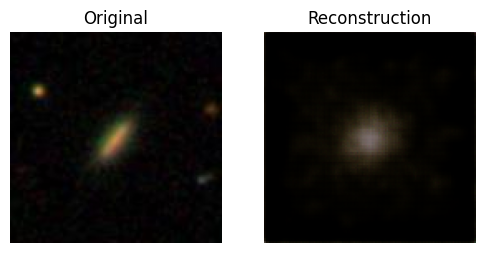

True: [0.73  0.243 0.027]
Pred : [0.65459573 0.30563247 0.03977175]


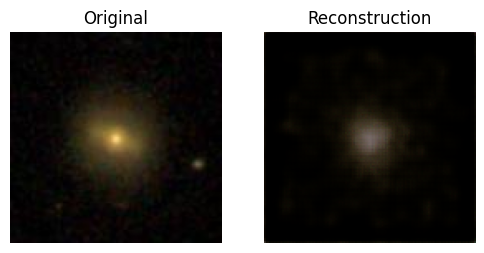

True: [0.459 0.514 0.027]
Pred : [0.67533344 0.27905813 0.04560845]


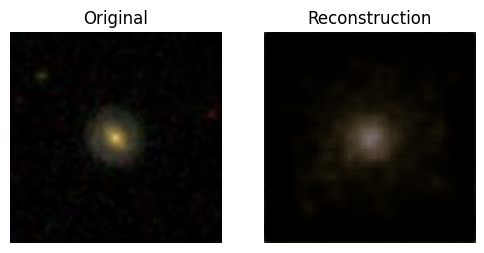

True: [0.837 0.116 0.047]
Pred : [0.6893661  0.27743065 0.03320318]


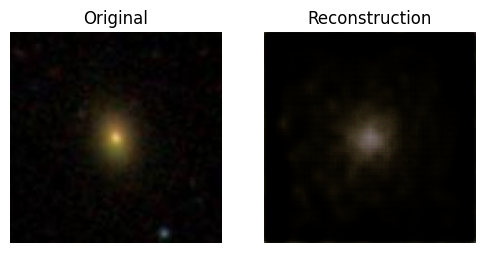

True: [0.744 0.233 0.023]
Pred : [0.61703163 0.34120366 0.04176469]


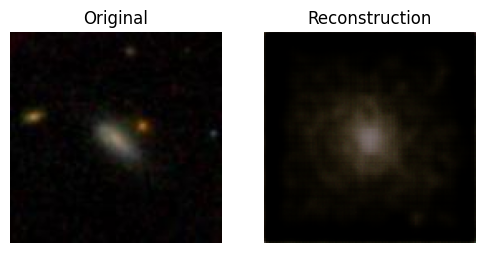

In [10]:
# STEP 8: Visualize and Save Outputs
import matplotlib.pyplot as plt
model.eval()
with torch.no_grad():
    sample_X, sample_y = next(iter(dataloader))
    sample_X = sample_X.to(DEVICE)
    recon, preds, _, _ = model(sample_X)

for i in range(5):
    plt.figure(figsize=(6,3))
    plt.subplot(1,2,1)
    plt.imshow(sample_X[i].cpu().permute(1,2,0))
    plt.title("Original")
    plt.axis('off')
    plt.subplot(1,2,2)
    plt.imshow(recon[i].cpu().permute(1,2,0))
    plt.title("Reconstruction")
    plt.axis('off')
    print(f"True: {sample_y[i].numpy()}")
    print(f"Pred : {preds[i].cpu().numpy()}")
    plt.show()


In [11]:
# STEP 9: Save zip + notebook to Drive
import shutil

# Zip images
shutil.make_archive(f"{drive_path}/galaxy_images_backup", 'zip', image_folder)

# Save notebook itself
!jupyter nbconvert --to notebook --output="{drive_path}/VAE1000.ipynb" /content/*.ipynb


[NbConvertApp] WARNING | pattern '/content/*.ipynb' matched no files
This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config_json=True]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.generate_config=True]
-y
    Answer yes to any questions instead of prompting.
    Equivalent to: [--JupyterApp.answer_yes=True]
--execute
    